In [39]:
import pandas as pd
import json
from globals import BASE_DIR
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from postprocess_baseline_top_k import dataset_metadata
from evaluation_metrics import ndcg, calculate_arp_poplift, evaluation_user_group_means, jensen_shannon, gini_index
import pingouin as pg

top_k_eval = 10

available_datasets = ["brightkite", "foursquaretky", "gowalla", "snowcard", "yelp"]

dataset = "yelp"
valid_popularity = "item_pop"
recommendation_dirpart = "recommendations"

In [40]:
def process_top_k_json(input_file, output_file, k=10):
    """
    Process top-k recommendations from a JSON file, keeping only the item IDs for each user.

    Args:
    - input_file (str): Path to the original JSON file.
    - output_file (str): Path to save the processed JSON file.
    - k (int): Number of top-k recommendations to keep per user.
    """
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    try:
        with open(input_file, 'r') as infile:
            data = json.load(infile)

        top_k_result = {}
        for user_id, recommendations in data.items():
            if recommendations and isinstance(recommendations[0], dict):
                item_ids = recommendations[0]["item_id"][:k]
                top_k_result[user_id] = item_ids

        with open(output_file, 'w') as outfile:
            json.dump(top_k_result, outfile, indent=4)
        print(f"Processed file saved to: {output_file}")
    
    except Exception as e:
        print(f"Error processing {input_file}: {e}")

In [41]:
def create_model_directories(dataset, data, base_dir, recommendation_dirpart):
    model_directories = {}
    methods = ["baseline", "cp", "cp_min_js", "upd"]

    def recommender_dir_combiner(dataset, modelpart, method):
        return f"{base_dir}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/{method + '/'}top_k_recommendations.json"

    for result in data:
        model_name = result["model"]
        model_directories[model_name] = {}
        
        for method in methods:
            model_directories[model_name][method] = recommender_dir_combiner(dataset, result["directory"], method)
    
    return model_directories

def sample_user_groups(user_groups, sample_size=100):
    sampled_groups = {}
    for group, ids in user_groups.items():
        if len(ids) >= sample_size:
            sampled_groups[group] = random.sample(ids, sample_size)
        else:
            print(f"Warning: Group '{group}' has less than {sample_size} users. Sampling all users.")
            sampled_groups[group] = ids
    return sampled_groups


def open_ground_truth_user_group(dataset, valid_popularity=valid_popularity):

    # Stays the same across all models 
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")

    print("Train data, test data and valid data shapes:")
    print(train_data.shape, test_data.shape, valid_data.shape)
    #valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t") # originale struktur !!!
    train_data = pd.concat([train_data, valid_data])
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    # checkin_df = pd.read_csv(
    #     f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter",
    #     sep="\t",
    # )

    checkin_df = train_data.copy()
    
    # Calculate item popularity
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    value_counts[valid_popularity] = value_counts["count"] / len(value_counts)
    checkin_df = checkin_df.merge(
        value_counts[["item_id:token", valid_popularity]],
        on="item_id:token",
        how="left",
    )
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[
        ["item_id:token", valid_popularity]
    ]

    h_group = item_popularity.head(int(len(item_popularity) * 0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity) * 0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[
        ~item_popularity["item_id:token"].isin(h_group["item_id:token"]) &
        ~item_popularity["item_id:token"].isin(t_group["item_id:token"])
    ]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group, m_group, t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)




    upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    upts.columns = ["user_id:token", "upts"]
    return train_data, test_data, user_groups, item_popularity, upts


In [42]:
data = dataset_metadata(dataset, recommendation_dirpart)

In [43]:
model_dirs = create_model_directories(dataset, data, BASE_DIR, recommendation_dirpart)

In [44]:
def unstack_recommendations(df):
    # Repeat each user_id for the length of their item_id:token list
    unstacked_df = df.explode(["item_id:token"]).reset_index(drop=True)
    return unstacked_df

In [45]:
def top_k_to_df(recommender_dir, top_k_eval=top_k_eval):
    # Load the JSON data
    with open(recommender_dir) as f:
        data = json.load(f)

    # Initialize a list to store the recommendations
    base_recommendations = []

    # Iterate through the data and structure it for DataFrame
    for user, items in data.items():
        for item in items:
            base_recommendations.append({
                "user_id:token": user,
                "item_id:token": item
            })

    # Create a DataFrame from the structured recommendations
    base_df = pd.DataFrame(base_recommendations)

    # Assuming `unstack_recommendations` is a function you want to apply here:
    base_df = unstack_recommendations(base_df)

    df = base_df.groupby('user_id:token').head(top_k_eval)

    return df


In [46]:
train_data, test_data, user_groups, item_popularity, upts = open_ground_truth_user_group(dataset)
user_groups['all'] = user_groups['high'] + user_groups['medium'] + user_groups['low']

Train data, test data and valid data shapes:
(22282, 3) (7633, 3) (5373, 3)


/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_4239/2055348030.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_4239/2055348030.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_4239/2055348030.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [47]:
def create_pop_distributions(data):
    data = data.merge(item_popularity, on="item_id:token", how="left")
    g1 = data.loc[data["user_id:token"].isin(user_groups["high"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["medium"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["low"])].value_counts("item_pop_group", normalize=True).rename("g3")
    all = data.value_counts("item_pop_group", normalize=True).rename("all")
    distr_df = pd.DataFrame([g1, g2, g3, all]).fillna(0)
    #distr_df.rename(index={"high": "g1", "medium": "g2", "low": "g3"}, inplace=True)
    return distr_df


ground_truth_distr = create_pop_distributions(train_data)

In [48]:
ground_truth_distr

item_pop_group,h,m,t
g1,0.710990,0.266569,0.022441
g2,0.442081,0.499832,0.058087
g3,0.290590,0.614717,0.094693
all,0.460676,0.480673,0.058651


In [49]:
def preprocess_distr(distr_df):
    distr_df.rename(index={"g1":"high", "g2":"medium", "g3":"low"}, inplace=True) # COMMENT IN FOR CALCULATING RESULTS, COMMENT OUT FOR PLOTTING
    data = distr_df.to_dict()
    result = []
    # Get user groups from any one of the nested dictionaries
    user_groups = data['h'].keys()

    for group in user_groups:
        # Extract h, m, t values for the current user group
        h_value = data.get('h', {}).get(group, 0)
        m_value = data.get('m', {}).get(group, 0)
        t_value = data.get('t', {}).get(group, 0)
        
        result.append({
            'user_group': group,
            'h_ratio': h_value,
            'm_ratio': m_value,
            't_ratio': t_value
        })

    return result


In [50]:
distr_dict_ground_truth = preprocess_distr(ground_truth_distr)


In [51]:
jsd_group = {}
for group_gt, group_recs in zip(distr_dict_ground_truth, distr_dict_ground_truth):
    jsd_group[group_gt['user_group']] = jensen_shannon(group_gt, group_recs)


In [52]:
jsd_group

{'high': 0.0, 'medium': 0.0, 'low': 0.0, 'all': 0.0}

In [53]:
ground_truth_distr

item_pop_group,h,m,t
high,0.710990,0.266569,0.022441
medium,0.442081,0.499832,0.058087
low,0.290590,0.614717,0.094693
all,0.460676,0.480673,0.058651


In [54]:
# Function for plotting popularity distribution (no legend inside this function)
def plot_popularity_distribution(ax, distr_df, label):
    colors = plt.cm.viridis([0.1, 0.5, 0.9])
    bars = distr_df.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False, edgecolor='black', linewidth=0, width=0.8)
    ax.set_title(f"{label}", fontsize=10)
    ax.set_xlabel("User Groups")
    ax.set_ylabel("Item Pop Ratio")
    return distr_df

def plot_line_chart(results, model_name, ax, metric, title):
    """
    Plot scores (nDCG, ARP, PopLift) as line plots for each user group, comparing methods.
    """
    methods = ["baseline", "cp", "cp_min_js", "upd"]
    user_groups = ["high", "medium", "low", "all"]
    group_labels = ["High", "Medium", "Low", "All"]

    # Extract metric scores for each method and user group
    metric_values = {
        method: [results[model_name][method][group][f"{metric}"] for group in user_groups]
        for method in methods
    }

    # Transpose values to plot lines for user groups
    metric_transposed = list(zip(*metric_values.values()))  # Group-wise scores across methods

    # Plot each user group's metric scores as a line plot
    colors = plt.cm.viridis([0.1, 0.5, 0.9, 0.3])
    for idx, group_label in enumerate(group_labels):
        ax.plot(methods, metric_transposed[idx], marker='o', label=group_label, color=colors[idx])

    # Set x-axis and y-axis labels and grid
    ax.set_ylabel(f"{metric.upper()} Score", fontsize=12)
    ax.grid(True)

    # Increase the font size of the x-axis tick labels (methods)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)




In [55]:
df = top_k_to_df("/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-SimpleX-Jan-22-2025_15-12-28/cp/top_k_recommendations.json")

In [56]:
flattened_item_ids = df["item_id:token"].values.tolist()
num_items = df["item_id:token"].nunique()
gini_index(flattened_item_ids, num_items)


0.6312240638428488

In [57]:
df = top_k_to_df('/Volumes/Forster Neu/Masterarbeit Data/yelp_dataset/recommendations/yelp_sample-BPR-Jan-22-2025_15-15-41/baseline/top_k_recommendations.json')

In [58]:
df

,user_id:token,item_id:token
0,749_x,199_x
1,749_x,1374_x
2,749_x,2926_x
3,749_x,101_x
4,749_x,490_x
...,...,...
224855,85_x,296_x
224856,85_x,3347_x
224857,85_x,1278_x
224858,85_x,635_x


In [ ]:
def calculate_t_test(group_ndcg_scores, group_arp_scores, group_poplift_scores):
    """Source t-test: https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/"""
    
    

    # Conducting two-sample ttest
    result = pg.ttest(data_group1, 
                    data_group2,
                    correction=True)
    

    
    return float(result["p-val"])

In [72]:
ndcg_scores = ndcg(df, test_data, top_k_eval)
df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)
group_eval,group_ndcg_scores, group_arp_scores, group_poplift_scores  = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups, df)

In [ ]:
data_group1 = list(group_ndcg_scores["low"].values())
data_group2 = list(group_ndcg_scores["high"].values())


ttest = calculate_t_test(data_group1, data_group2)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [74]:
data_group1 = list(group_ndcg_scores["low"].values())
data_group2 = list(group_ndcg_scores["medium"].values())

ttest = calculate_t_test(data_group1, data_group2)

/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_4239/1219916455.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(result["p-val"])


In [75]:
ttest

0.0024616872764062865

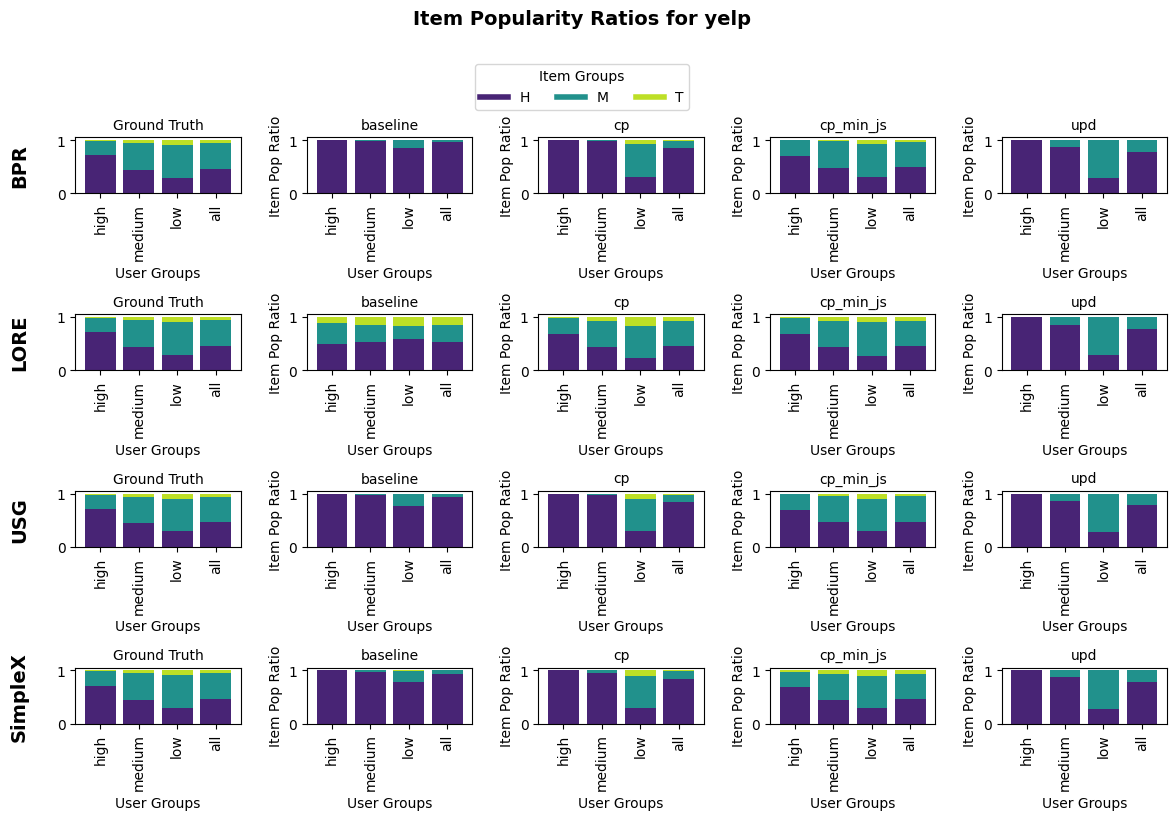

In [ ]:


results = {}
fig, axs = plt.subplots(len(model_dirs), 5, figsize=(12, 12))  # Adjusted for nDCG plots

for i, (model_name, methods) in enumerate(model_dirs.items()):
    results[model_name] = {}

    # Plot the ground truth in the first column
    ax = axs[i, 0]
    plot_popularity_distribution(ax, ground_truth_distr, "Ground Truth")

    for j, (method_name, json_file) in enumerate(methods.items()):
        # with open(json_file, 'r') as f:
        #     eval_data = json.load(f)

        df = top_k_to_df(json_file)
        ndcg_scores = ndcg(df, test_data, top_k_eval)
        df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
        arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)
        distr_df = create_pop_distributions(df)
        distr_dict_recs = preprocess_distr(distr_df)


        jsd_group = {}
        for group_gt, group_recs in zip(distr_dict_ground_truth, distr_dict_recs):
            jsd_group[group_gt['user_group']] = jensen_shannon(group_gt, group_recs)

        group_eval, group_ndcg_scores, group_arp_scores, group_poplift_scores = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups, df)

        for group_name, jsd_value in jsd_group.items():
            if group_name in group_eval:
                group_eval[group_name]["js"] = jsd_value
            else:
                # In case the group exists in jsd_group but not in group_eval
                group_eval[group_name] = {"js": jsd_value}

        results[model_name][method_name] = group_eval

        ax = axs[i, j + 1]
        plot_popularity_distribution(ax, distr_df, method_name)

    axs[i, 0].set_ylabel(model_name, fontsize=14, weight='bold', labelpad=20)

fig.suptitle(f"Item Popularity Ratios for {dataset}", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0.3, 1, 0.93])  # Reduced space between title and legend

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in plt.cm.viridis([0.1, 0.5, 0.9])]
labels = ["H", "M", "T"]
fig.legend(handles, labels, title="Item Groups", loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=3)

#plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/{dataset}_popularity_distribution.png")

In [160]:
def plot_metric(results, metric, dataset):
    n_models = len(results)
    n_cols = 4
    n_rows = math.ceil(n_models / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axs = axs.flatten()  # Flatten to simplify indexing

    for i, (model_name, methods) in enumerate(results.items()):
        plot_line_chart(results, model_name, axs[i], metric, f"{metric.upper()} Scores")
        axs[i].set_ylabel(model_name, fontsize=14, weight='bold')

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])  # Remove unused subplots

    fig.suptitle(f"{metric.upper()} Comparison for {dataset}", fontsize=18, weight='bold')

    ndcg_handles = [plt.Line2D([0], [0], color=color, lw=2, marker='o') for color in plt.cm.viridis([0.2, 0.6, 0.8, 0.3])]
    ndcg_labels = ["g1", "g2", "g3", "all"]
    fig.legend(ndcg_handles, ndcg_labels, title="User Groups", loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=4)

    plt.tight_layout(rect=[0, 0.02, 1, 0.88])  # Reduced bottom space
    plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/{dataset}_{metric}_comparison.png")






In [161]:
# results = {}

# for model_name, methods in model_dirs.items():
#     results[model_name] = {}

#     for method_name, json_file in methods.items():
#         df = top_k_to_df(json_file)
#         ndcg_scores = ndcg(df, test_data, top_k_eval)
#         df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
#         arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)
#         distr_df = create_pop_distributions(df)
#         distr_dict_recs = preprocess_distr(distr_df)

#         jsd_group = {group_gt['user_group']: jensen_shannon(group_gt, group_recs)
#                         for group_gt, group_recs in zip(distr_dict_ground_truth, distr_dict_recs)}

#         group_eval = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups)

#         for group_name, jsd_value in jsd_group.items():
#             group_eval.setdefault(group_name, {})['js_mean'] = jsd_value

#         results[model_name][method_name] = group_eval

In [162]:
results

{'BPR': {'baseline': {'high': {'ndcg': 0.06496547341333402,
    'arp': 0.009303023465703992,
    'poplift': 1.054221094834826,
    'gini': 0.651469816272966,
    'js': 0.1590926713688374},
   'medium': {'ndcg': 0.030368694600326842,
    'arp': 0.007904457480946616,
    'poplift': 2.3982883309580454,
    'gini': 0.7481249660418363,
    'js': 0.3104501610159752},
   'low': {'ndcg': 0.01917267525934426,
    'arp': 0.003965027075812292,
    'poplift': 1.7702482444893894,
    'gini': 0.6373688271604936,
    'js': 0.2659778473726916},
   'all': {'ndcg': 0.03504884649473182,
    'arp': 0.007396284596871164,
    'poplift': 2.003866866439671,
    'gini': 0.7692413472706157,
    'js': 0.25453252800162834}},
  'cp': {'high': {'ndcg': 0.06496547341333402,
    'arp': 0.009301669675090272,
    'poplift': 1.0538493853361495,
    'gini': 0.651469816272966,
    'js': 0.15665400738610055},
   'medium': {'ndcg': 0.030718561412179764,
    'arp': 0.007893777577216172,
    'poplift': 2.3930218952842828,
   

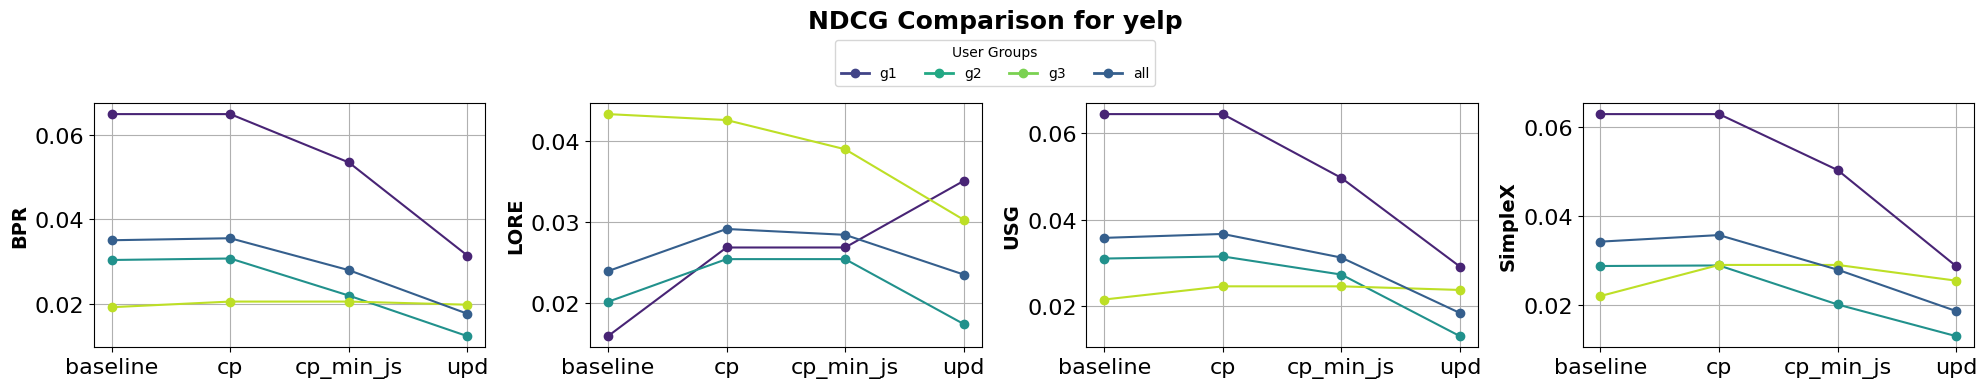

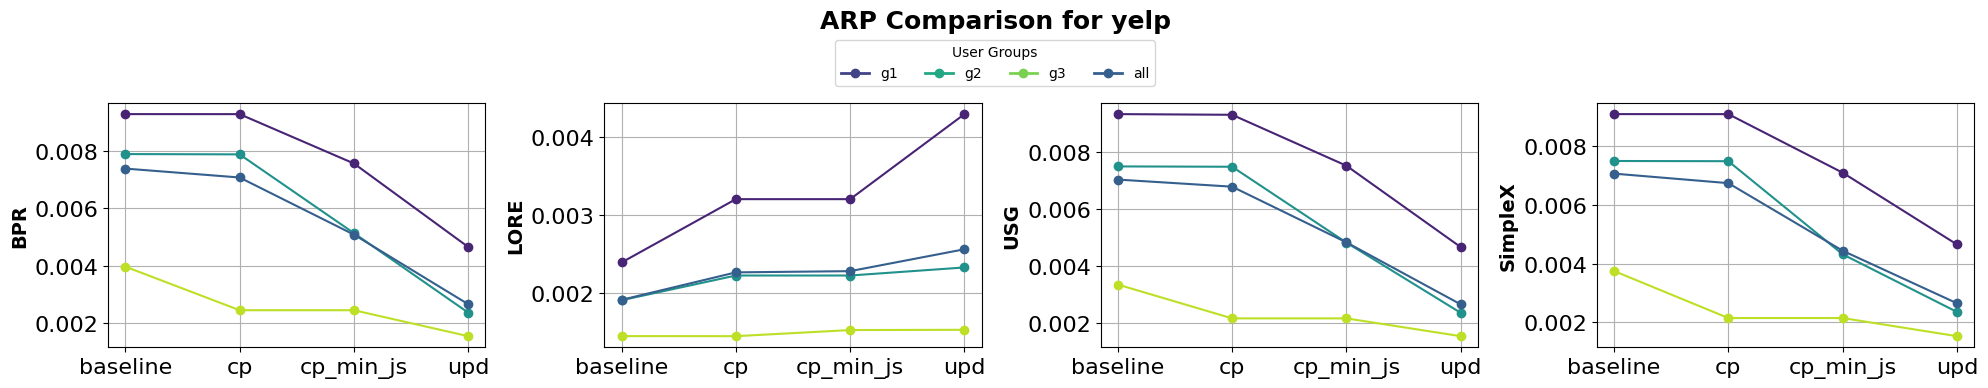

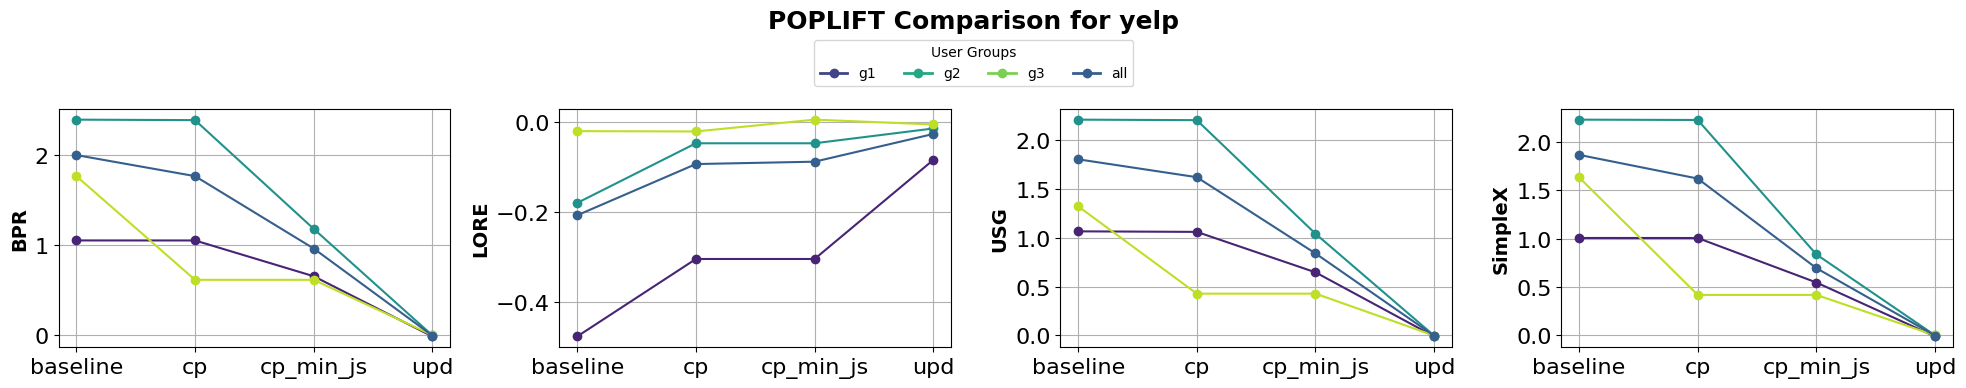

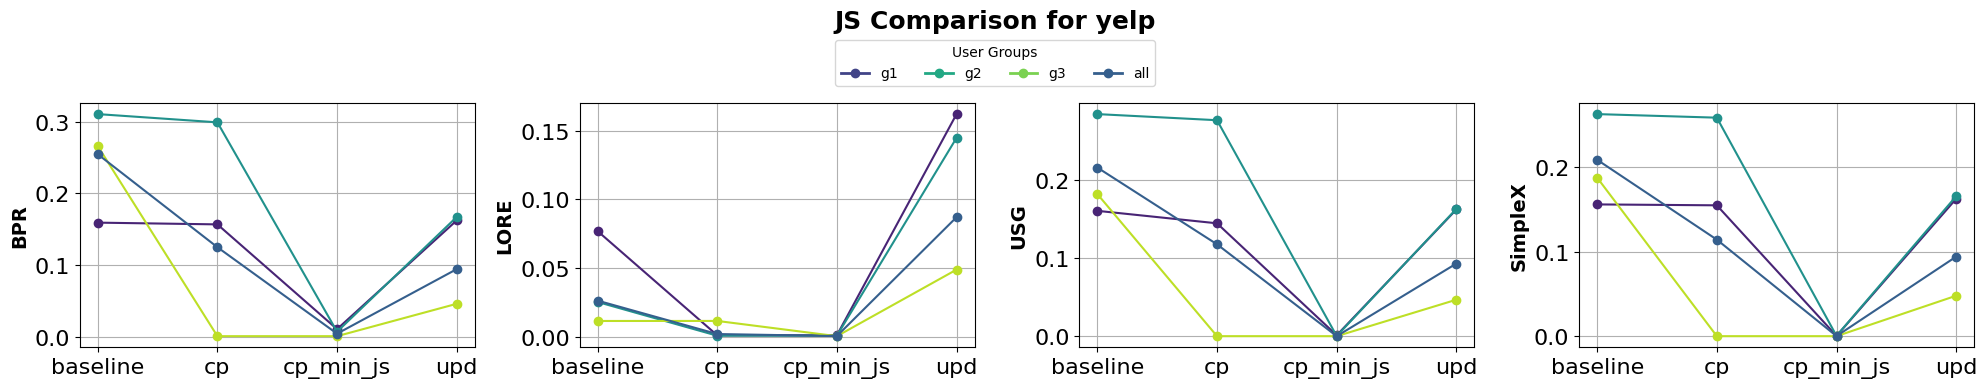

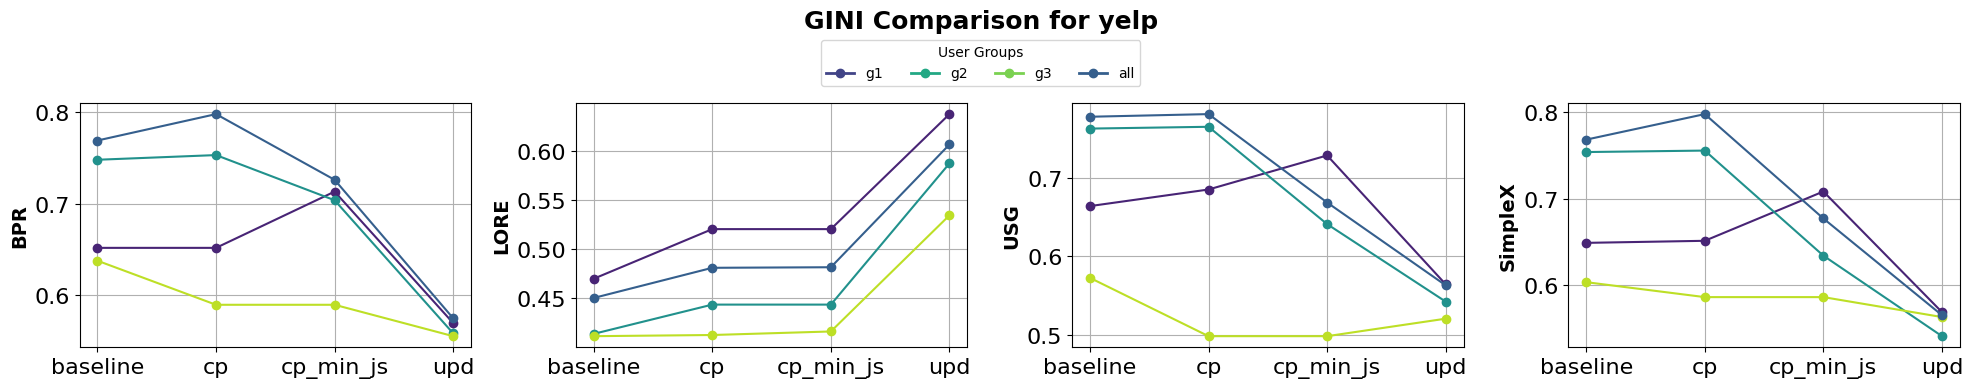

In [163]:

#plot_popularity_distributions(model_dirs, ground_truth_distr, dataset)
plot_metric(results, "ndcg", dataset)
plot_metric(results, "arp", dataset)
plot_metric(results, "poplift", dataset)
plot_metric(results, "js", dataset)
plot_metric(results, "gini", dataset)

In [164]:
# Collect results into rows for CSV output
rows = []
for model_name, methods in results.items():
    for method_name, group_eval in methods.items():
        for group_name, metrics in group_eval.items():
            row = {
                'dataset': dataset,
                'model': model_name,
                'method': method_name,
                'user_group': group_name,
                'ndcg': metrics['ndcg'],
                'arp': metrics['arp'],
                'poplift': metrics['poplift'],
                'js': metrics['js'],
                'gini': metrics['gini'],
                
            }
            rows.append(row)

# Create a DataFrame from the rows
df_results = pd.DataFrame(rows)

# Save the evaluation results to a CSV file
df_results.to_csv(f'{BASE_DIR}/{dataset}_dataset/evaluation_results.csv', index=False)
# print("Evaluation results have been saved to 'evaluation_results.csv'")

In [165]:
df_results.head(50)

,dataset,model,method,user_group,ndcg,arp,poplift,js,gini
0,yelp,BPR,baseline,high,0.064965,0.009303,1.054221,0.159093,0.651470
1,yelp,BPR,baseline,medium,0.030369,0.007904,2.398288,0.310450,0.748125
2,yelp,BPR,baseline,low,0.019173,0.003965,1.770248,0.265978,0.637369
3,yelp,BPR,baseline,all,0.035049,0.007396,2.003867,0.254533,0.769241
4,yelp,BPR,cp,high,0.064965,0.009302,1.053849,0.156654,0.651470
5,yelp,BPR,cp,medium,0.030719,0.007894,2.393022,0.298965,0.753261
6,yelp,BPR,cp,low,0.020503,0.002440,0.616124,0.000758,0.589020
7,yelp,BPR,cp,all,0.035525,0.007085,1.769808,0.124820,0.798218
8,yelp,BPR,cp_min_js,high,0.053499,0.007575,0.655935,0.010565,0.713202
9,yelp,BPR,cp_min_js,medium,0.021922,0.005138,1.183131,0.006997,0.703714


In [166]:

# 1. Best nDCG for each model and user group
best_ndcg_per_model_group = df_results.loc[df_results.groupby(['model', 'user_group'])['ndcg'].idxmax()]

# 2. Best overall nDCG for each user group
best_overall_ndcg_per_group = df_results.loc[df_results.groupby(['user_group'])['ndcg'].idxmax()]

# Display or save the results
print("Best nDCG for each model and user group:")
print(best_ndcg_per_model_group)

print("\nBest overall nDCG for each user group:")
print(best_overall_ndcg_per_group)


best_ndcg_per_model_group.to_csv(f'{BASE_DIR}/{dataset}_dataset/best_ndcg_per_model_group.csv', index=False)
best_overall_ndcg_per_group.to_csv(f'{BASE_DIR}/{dataset}_dataset/best_overall_ndcg_per_group.csv', index=False)

Best nDCG for each model and user group:
   dataset    model    method user_group      ndcg       arp   poplift  \
7     yelp      BPR        cp        all  0.035525  0.007085  1.769808   
0     yelp      BPR  baseline       high  0.064965  0.009303  1.054221   
6     yelp      BPR        cp        low  0.020503  0.002440  0.616124   
5     yelp      BPR        cp     medium  0.030719  0.007894  2.393022   
23    yelp     LORE        cp        all  0.029155  0.002260 -0.093434   
28    yelp     LORE       upd       high  0.035105  0.004288 -0.084364   
18    yelp     LORE  baseline        low  0.043362  0.001443 -0.020289   
21    yelp     LORE        cp     medium  0.025427  0.002220 -0.047266   
55    yelp  SimpleX        cp        all  0.035683  0.006738  1.621596   
48    yelp  SimpleX  baseline       high  0.062778  0.009089  1.005800   
54    yelp  SimpleX        cp        low  0.028997  0.002145  0.415949   
53    yelp  SimpleX        cp     medium  0.028880  0.007485  2.228826 